# Data Processing and Cleaning

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
# import ollama
import csv
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score,confusion_matrix
import shap
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from tqdm import tqdm  
from nltk.corpus import stopwords






In [ ]:
# directory = '.\\goodreads' # directory where the json files were stored

### Joining of the data with equally distribution of genders and ratings
- We left the directory out of submition to save space only left the code for example and the output file
- The output of the below code yield the `filtered_data_equalRating_dist.csv` that was then used to train and evaluate the models

In [ ]:
# order = ['children', 'comics_graphics', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'poetry', 'romance', 'young_adult']
# final_df = pd.DataFrame()

# index = -1
# for filename in os.listdir(directory):
#     if filename.endswith('.json'):
#         index+=1
#         filename = os.path.join(directory, filename)
#         with open(filename, 'r') as file:
#             counter = 0
#             counterR0 = 0
#             counterR1 = 0
#             counterR2 = 0
#             counterR3 = 0
#             counterR4 = 0
#             counterR5 = 0
#             jsonData = []
#             for line in file:
#                 json_line = json.loads(line)
#                 rating = json_line["rating"]
                
#                 if int(rating) == 0 and counterR0 <= counter / 6:
#                     counterR0 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 1 and counterR1 <= counter / 6:
#                     counterR1 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 2 and counterR2 <= counter / 6:
#                     counterR2 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 3 and counterR3 <= counter / 6:
#                     counterR3 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 4 and counterR4 <= counter / 6:
#                     counterR4 += 1
#                     jsonData.append(json_line)
#                 elif int(rating) == 5 and counterR5 <= counter / 6:
#                     counterR5 += 1
#                     jsonData.append(json_line)
                    
#                 counter = counterR0 + counterR1 + counterR2 + counterR3 + counterR4 + counterR5 
#                 print(counter)
#                 if (counter) == 5000:
#                     break
                
#             jsonDataFrame = pd.DataFrame(jsonData)
#             jsonDataFrame["type"] = order[index]
#             final_df = pd.concat([final_df, jsonDataFrame], axis=0)
# final_df.to_csv('filtered_data_equalRating_dist.csv', index=False)

# Using ollama, ollama-python and Llhama 3.2 model to predict ratings
- To be able to run the Llama 3.2 with Ollama, the user should have the following installed:
    - Download and install [Ollama](https://ollama.com/download)
    - Install the Llama 3.2 model using `ollama run llama3.2`
    - Make sure Ollama is up and running and also have installed [ollama-python](https://github.com/ollama/ollama-python) with `pip install ollama`

In [3]:
df = pd.read_csv('filtered_data_equalRating_dist.csv')
df.drop(columns=["user_id", "review_id", "book_id"], inplace=True) # drop columns that are not needed
df = df.dropna(subset=['review_text']) # drop rows with missing values
df["review_text"] = df["review_text"].astype(str)

### Prompt used Inspired by [Text Classification with Large Language Models (LLMs)](https://hussainpoonawala.medium.com/text-classification-with-large-language-models-llms-a23c731a687e) by Hussain Poonawala.

### Sampled into 1500 of each rating

In [ ]:
# Split the dataframe into 5 for each rating with 20 of each
# dfs = []
# for rating in range(0, 6):
#     dfs.append(df[df['rating'] == rating].sample(n=1500, random_state=1))
# df_sampled = pd.concat(dfs).reset_index(drop=True)

### Using the prompt for rating prediction
- It as fail safe assertions for non-blocking code
- The prompt consists of asking for Llhama 3.2 to output a json with format:
{{
"predictedRating": "",
"auditReasons": [],
"reason": ""
}}
- The prompt also has a `multiple shot approach` which allow the model to reason better about the response it should yield
- The json data is the parsed and saved in real time to the `predicted_ratings.csv` to allow multiple runs

In [4]:
# i = 0
# n_trues = 0
# n_falses = 0

# df_sampled = pd.read_csv('sampled_data.csv')
# # Open a CSV file to write the JSON output
# with open('predicted_ratings.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Real Rating', 'Predicted Rating', 'Assertion', 'Audit Reasons', 'Iteration', 'StartTime', 'EndTime', 'Duration'])

#     while i <= 9000:
#         # Record the start time
#         start_time = time.time()
#         review_text = df_sampled.iloc[i]['review_text']
        
#         prompt = f"""
#             You are tasked with classifying a book review based on a human's rating on a scale of 0 to 5, reflecting their overall satisfaction with the book. The review is the following: "{review_text}".
#             The review was posted on an online book reviewing platform. Use the following criteria to guide your classification:
#             **Rating Scale**:
#             1. 0 - Really Bad
#             1. 1 - Very Bad
#             2. 2 - Bad
#             3. 3 - Average
#             4. 4 - Good
#             5. 5 - Very Good

#             **Guidelines**:
#             1. Read the review carefully, paying attention to both the explicit content and implied sentiments.
#             2. Think like a human reviewer and infer the overall impression and satisfaction level of the user from the text.
#             3. Avoid simple keyword matching or sentiment analysis. Instead, consider the deeper meaning and tone of the review.
            
#             **Key Aspects to Consider**:
#             - **Sentiment**: Is the overall tone positive, negative, or neutral?
#             - **Engagement**: Does the reviewer seem deeply involved with the book or detached and indifferent?
#             - **Plot and Character Satisfaction**: Are there complaints about the plot or characters that indicate dissatisfaction, or praise that suggests satisfaction?
#             - **Recommendation Willingness**: Does the reviewer express a desire to recommend the book to others, or show reluctance?

#             **Audit Reason Categories**:
#             You must select one reason that justifies your classification, using the following categories:
#             1. Positive Sentiment
#             2. Negative Sentiment
#             3. Neutral Sentiment
#             4. Plot Dissatisfaction
#             5. Character Dissatisfaction
#             6. Lack of Engagement
#             7. Recommendation Hesitation
#             8. Pacing Issues
#             9. Repetition (Feeling of Deja Vu)
#             10. General Enjoyment

#             **DOs**:
#             1. Be specific and clear in your audit reasoning.
#             2. Think like a human reviewer, understanding the overall impression, tone, and the context of the book being reviewed.
#             3. Consider nuanced factors like pacing, emotional engagement, and depth of plot/character development.
#             4. Use the Output Format provided below to structure your response.
            
#             **DON'Ts**:
#             1. Do not rely purely on word choices for classification.
#             2. Avoid guesses or assumptions. Base your classification solely on the review content provided.
#             3. Do not repeat the same audit reasons unless strongly justified by the review.
#             4. Do not add any additional information before or after the Output Format, i really just want to see the json output.
#             5. Do not include any extra characters in the output.

#             **Output Format**:
#             {{
#             "predictedRating": "",
#             "auditReasons": [],
#             "reason": ""
#             }}

#             Examples:

#             1. Review: 'One of my favorite books to read to my 5-year-old. Beautifully written and keeps them engaged the whole time.'
#             Output: {{ predictedRating: "5", auditReasons: ['Positive Sentiment'], "reason": "The reviewer expresses clear satisfaction." }}

#             2. Review: 'Fun sequel to the original, but not quite as captivating.'
#             Output: {{ predictedRating: "4", auditReasons: ['Positive Sentiment'], "reason": "Generally positive but less engaging." }}

#             3. Review: 'I'm getting bored... it's the same book, over and over again. But now I'm invested in finding out what happens to these children.'
#             Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Dissatisfaction with repetition." }}

#             4. Review: 'The characters were well-written, but the pacing was just too slow. Took me a long time to finish.'
#             Output: {{ predictedRating: "3", auditReasons: ['Neutral Sentiment'], "reason": "Mixed feelings about pacing." }}

#             5. Review: 'I wanted to love it, but the plot was too predictable. I wouldn't recommend it to others.'
#             Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Disappointment with predictable plot." }}
            
#             6. Review: 'Huh, loppuipa vihdoin. Lopun paljastus siita, etta Narnia onkin taivas, ei ollut todellakaan mikaan yllatys. Kokonaisuudessaan Narnia ei tosiaan ole kirjasarja omaan makuuni ja luulen, etta jos olisin lukenut kirjat nuorempana, olisi suhtautuminen varmaan toinen. Nyt, ateistina, liian paalleliimattu kristillisyys arsytti, samoin Aslanin hahmo. Aikarakenteen muuttuminen kirjasta toiseen oli vahan omituinen ratkaisu, tosin kirjat olisi voinut myos lukea kronologisessa jarjestyksessa... Juonet kirjoissa olivat aika suoraviivaisia (ehka viimeista kirjaa lukuunottamatta) ja satumaisia, hahmot yksiulotteisia ja aika yhdentekevia. Maailman kuvaus toimi hyvin, mutta motiivien ja syiden kertominen ei. Aika yhdentekevia kirjoja minulle.'
#             Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
#             7. Review: 'I really don't like this book. It makes it seem like the baby's interactions are almost exclusively through social media. Plus, the illustrations are not very inspiring.'
#             Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
#             Please follow the guidelines strictly and classify based on the full context of the review.
#             """
#         response = ollama.generate(model='llama3.2:latest', prompt=prompt, format="json", options=ollama.Options(timeout=360000))["response"]
#         # Parse the response into JSON string
#         try:
#             parsed_json_response = json.loads(response)
#         except json.JSONDecodeError as e:
#             continue
#         # Accessing the parsed JSON data
#         predicted_rating = parsed_json_response["predictedRating"]
#         audit_reasons = parsed_json_response["auditReasons"]
#         # reason = parsed_json_response["reason"]
#         real_rating = df_sampled.iloc[i]['rating']
#         try:
#             assertion = real_rating == int(predicted_rating)
#         except ValueError as e:
#             print(f"Error converting predicted rating to int: {e}")
#             continue
#         print(f"Real Rating: {real_rating}, Predicted Rating: {predicted_rating}, Assertion: {assertion}")
        
#         # Record the end time
#         end_time = time.time()
#         duration = end_time - start_time
        
#         n_trues += 1 if assertion else 0
#         n_falses += 1 if not assertion else 0
        
#         print("Percentage of True Predictions: ", n_trues / (n_trues + n_falses) * 100)
        
#         # Write the data to the CSV file
#         writer.writerow([real_rating, predicted_rating, assertion, audit_reasons, i, start_time, end_time, duration])
#         file.flush()  # Ensure data is written to the file at each iteration
        
#         i += 1

NameError: name 'ollama' is not defined

### Evalutation of the LLM model for rating prediction
- To evaluate the LLM results, we load the outputted data from the `combined_predicted_ratings.csv`, which corresponds to the `9000 row predictions` that was the longest run we were able to do.
- We evaluated the model with and without the 0 rating for comparison because most of the 0 ratings were positive sentiments or ambiguous language, which made it hard for the model to predict accurately.
- To compare, we used confusion matrices and a classification report from `sklearn.metrics` that provides the most important metrics such as precision, recall, F1-score, and accuracy.

#### Without the 0 rating

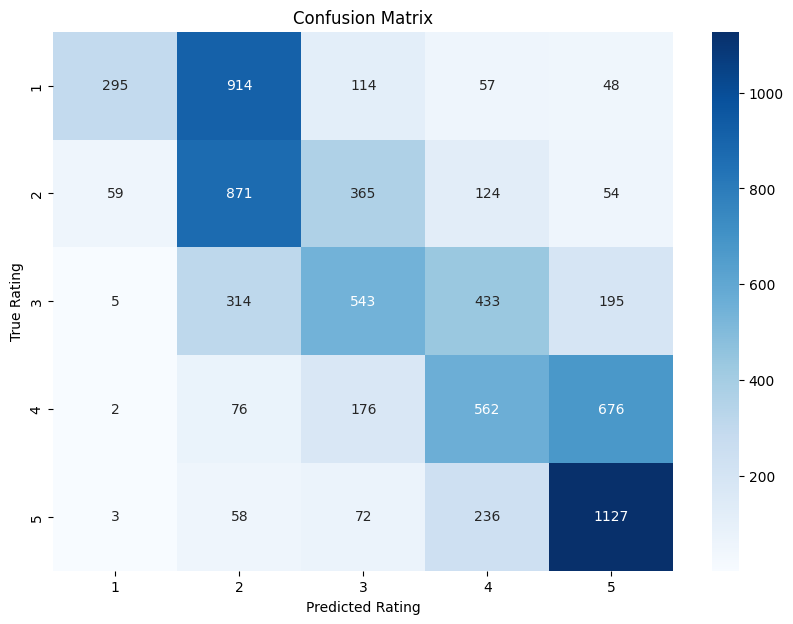

,precision,recall,f1-score,support
1,0.810440,0.206583,0.329241,1428.000000
2,0.390058,0.591310,0.470049,1473.000000
3,0.427559,0.364430,0.393478,1490.000000
4,0.398017,0.376676,0.387052,1492.000000
5,0.536667,0.753342,0.626808,1496.000000
accuracy,0.460496,0.460496,0.460496,0.460496
macro avg,0.512548,0.458468,0.441326,7379.000000
weighted avg,0.510316,0.460496,0.442337,7379.000000


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')
df_predicted = df_predicted[(df_predicted["Real Rating"] != 0) & (df_predicted["Predicted Rating"] != 0)]

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

#### With 0 rating

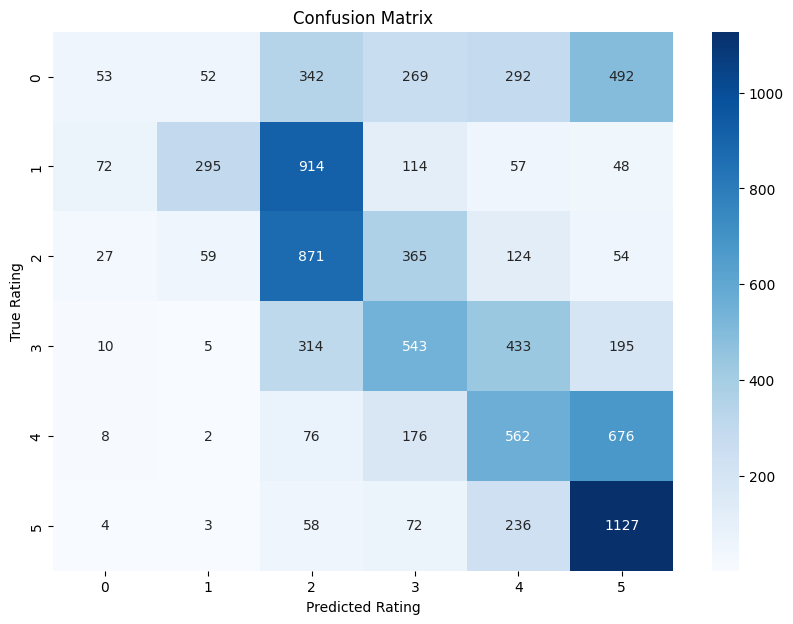

,precision,recall,f1-score,support
0,0.304598,0.035333,0.063321,1500.000000
1,0.709135,0.196667,0.307933,1500.000000
2,0.338252,0.580667,0.427485,1500.000000
3,0.352827,0.362000,0.357354,1500.000000
4,0.329812,0.374667,0.350811,1500.000000
5,0.434799,0.751333,0.550831,1500.000000
accuracy,0.383444,0.383444,0.383444,0.383444
macro avg,0.411570,0.383444,0.342956,9000.000000
weighted avg,0.411570,0.383444,0.342956,9000.000000


In [6]:
# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(0, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

## Linear Regression

### First Approach - Simple Linear Regressionn

Mean Squared Error: 2.531186857366897
Root Mean Squared Error: 1.5909704137308454
R^2: -1.1964862895890511
Confusion Matrix:


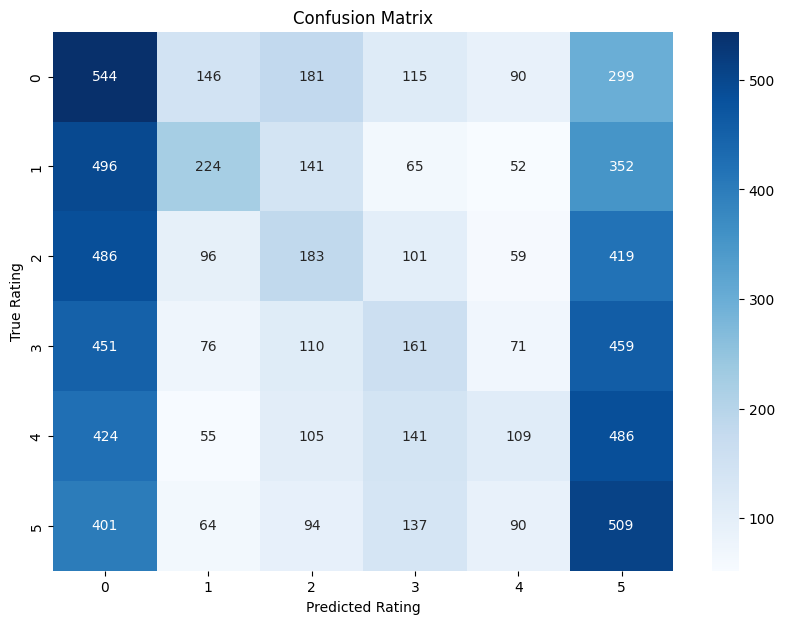

              precision    recall  f1-score      support
0              0.194147  0.395636  0.260474  1375.000000
1              0.338880  0.168421  0.225013  1330.000000
2              0.224816  0.136161  0.169601  1344.000000
3              0.223611  0.121235  0.157227  1328.000000
4              0.231423  0.082576  0.121720  1320.000000
5              0.201664  0.393050  0.266562  1295.000000
accuracy       0.216466  0.216466  0.216466     0.216466
macro avg      0.235757  0.216180  0.200099  7992.000000
weighted avg   0.235661  0.216466  0.200204  7992.000000


In [33]:
#data preprocessing
df = pd.read_csv('filtered_data_equalRating_dist.csv')
df.drop(columns=["user_id", "review_id", "book_id"], inplace=True)
df = df.dropna(subset=['review_text'])
df["review_text"] = df["review_text"].astype(str)
df



X = df['review_text']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, 5).round().astype(int)

print('Mean Squared Error:', metrics.root_mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.root_mean_squared_error(y_test, y_pred)))
print ('R^2:', metrics.r2_score(y_test, y_pred))

#confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1, 2, 3, 4, 5], yticklabels=[0,1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_repo = pd.DataFrame(report).transpose()
print(df_repo)



## Second Aproach - Linear Regression with Ridge Regression and Grid Seacrh 

#### includes Words Importance with SHAP

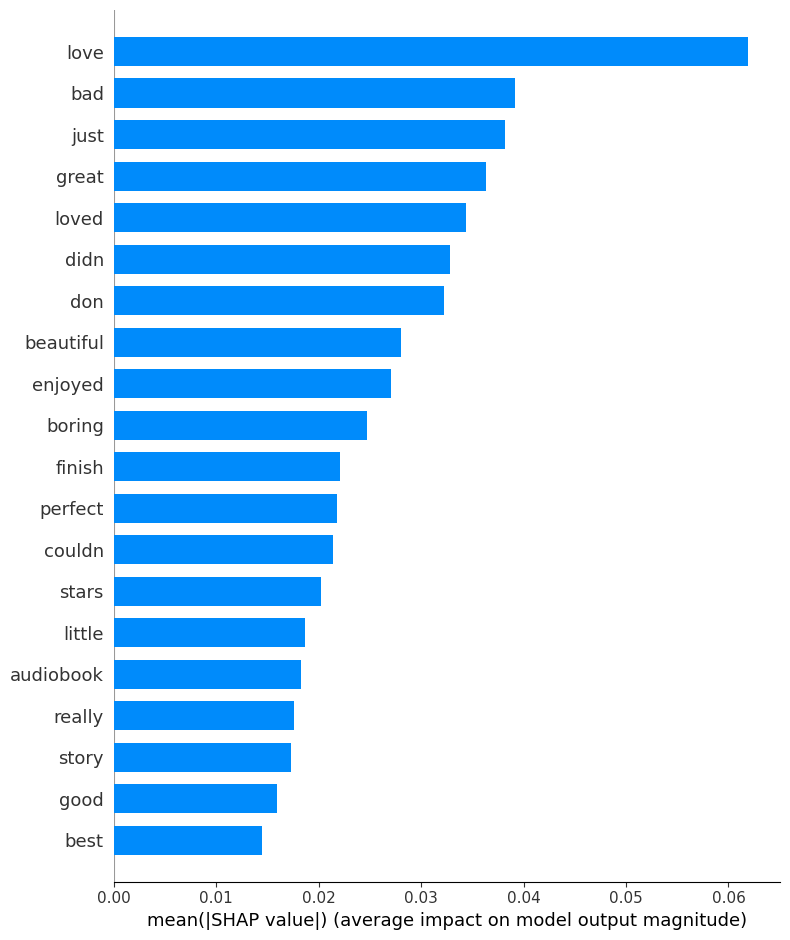

In [43]:

# Data preprocessing
df = pd.read_csv('filtered_data_equalRating_dist.csv')
df.drop(columns=["user_id", "review_id", "book_id"], inplace=True)
df = df.dropna(subset=['review_text'])
df["review_text"] = df["review_text"].astype(str)



# Split data into train and test sets
X = df['review_text']
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


# Use Ridge Regression with Grid Search for hyperparameter tuning
ridge = Ridge()
parameters = {'alpha': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(ridge, parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out(), plot_type='bar')

# Predictions
y_pred = best_model.predict(X_test)
y_pred = np.clip(y_pred, 0, 5).round().astype(int)


#### Words Importance with TD-IDF

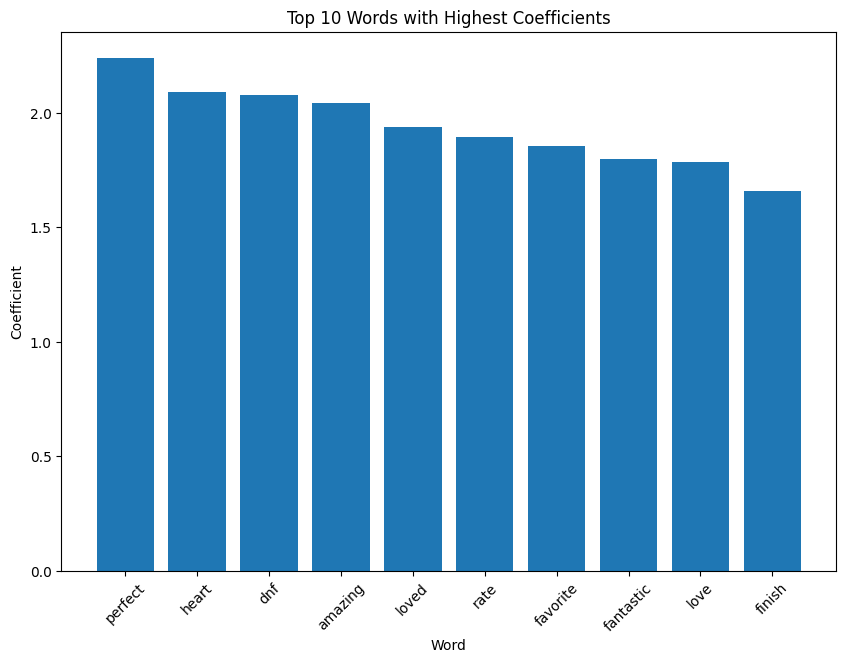

In [44]:
feature_names = vectorizer.get_feature_names_out()
coefficients = best_model.coef_


coef_df = pd.DataFrame({'Word': feature_names, 'Coefficient': coefficients})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


#plot 
plt.figure(figsize=(10, 7))
plt.bar(coef_df['Word'][:10], coef_df['Abs_Coefficient'][:10])
plt.xlabel('Word')
plt.ylabel('Coefficient')
plt.title('Top 10 Words with Highest Coefficients')
plt.xticks(rotation=45)
plt.show()

### Evaluation of the model

Mean Squared Error: 1.5393568850723407
Root Mean Squared Error: 1.2407082191524084
R^2: 0.18762094070311985
Confusion Matrix:


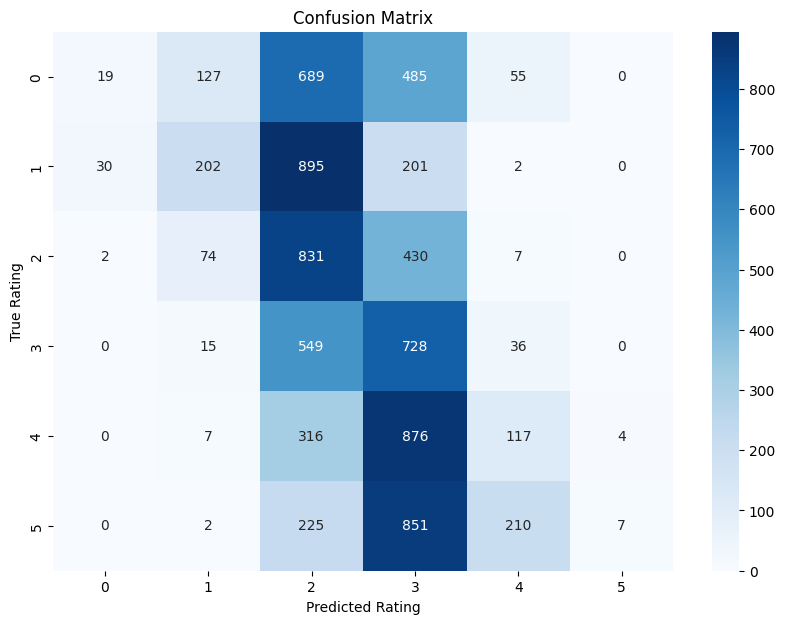

              precision    recall  f1-score      support
0              0.372549  0.013818  0.026648  1375.000000
1              0.473068  0.151880  0.229937  1330.000000
2              0.237090  0.618304  0.342751  1344.000000
3              0.203864  0.548193  0.297204  1328.000000
4              0.274005  0.088636  0.133944  1320.000000
5              0.636364  0.005405  0.010720  1295.000000
accuracy       0.238238  0.238238  0.238238     0.238238
macro avg      0.366157  0.237706  0.173534  7992.000000
weighted avg   0.364939  0.238238  0.173735  7992.000000


In [45]:
# Evaluation
print('Mean Squared Error:', metrics.root_mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.root_mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

#confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1, 2, 3, 4, 5], yticklabels=[0,1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_repo = pd.DataFrame(report).transpose()
print(df_repo)

### K-Fold Cross Validation

In [47]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = cross_val_score(best_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(best_model, X_train, y_train, cv=kf, scoring='r2')

print('Cross-validated MSE:', -mse_scores.mean())
print('Cross-validated R^2:', r2_scores.mean())

#accuracy of the model
accuracy = np.mean(np.abs(y_test - y_pred) <= 0.5)
print('Custom Accuracy:', accuracy)

best_model.fit(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"Test Set Accuracy: {test_accuracy:.2f}")

Cross-validated MSE: 2.3437643718859276
Cross-validated R^2: 0.19506165098682032
Custom Accuracy: 0.23823823823823823
Test Set Accuracy: 0.22


## Creation of a classifier that classifies the book category based on the readers’ reviews

### Preparing the dataset

In [ ]:
# Load the dataset
data = pd.read_csv('filtered_data_equalRating_dist.csv')
data = data.dropna(subset=['review_text'])

# Define genres and sample 150 reviews per genre for balance
dfs = []
generos = ['children','comics_graphics','fantasy_paranormal','history_biography','mystery_thriller_crime','poetry','romance','young_adult']

for genero in generos:
    dfs.append(data[data['type'] == genero].sample(n=150, random_state=1))
df_sampled = pd.concat(dfs).reset_index(drop=True)

# Encode the target labels (categories/genres)
label_encoder = LabelEncoder()
df_sampled['label'] = label_encoder.fit_transform(df_sampled['type'])

# Check the mapping from labels to original categories
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function for reviews
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')

# Dataset class for BERT inputs
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        tokenized_review = tokenize_function(self.reviews.iloc[idx])
        
        input_ids = tokenized_review['input_ids'].squeeze(0)
        attention_mask = tokenized_review['attention_mask'].squeeze(0)

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }
    
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_sampled['review_text'], df_sampled['label'], test_size=0.2, random_state=42)

# Create the training and testing datasets using the custom Dataset class
train_dataset = ReviewsDataset(X_train, y_train)
test_dataset = ReviewsDataset(X_test, y_test)

# Load pre-trained BERT model with a classification head
num_labels = len(df_sampled['label'].unique())  
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

### Training the model

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',           # output directory
    evaluation_strategy='epoch',      # evaluate during training
    per_device_train_batch_size=8,    # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    num_train_epochs=3,               # number of training epochs
    weight_decay=0.01,                # strength of weight decay
)

# Metric computation function
def compute_metrics(pred):
    logits, labels = pred
    logits = torch.tensor(logits)  
    predictions = torch.argmax(logits, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

# Train the model
trainer.train()

results = trainer.evaluate()
print(f"Evaluation results: {results}")

# Specify a directory to save the model
model_save_path = './saved_model'

# Save the model
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

### Load the trained model (in case it is needed later)

In [ ]:
# Load model and tokenizer from saved directory
model_save_path = './saved_model'
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

### Plot the Evaluation metrics and the confusion matrix

In [ ]:
# Get predictions and true labels from the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Extract evaluation metrics
metrics = ['accuracy', 'f1', 'precision', 'recall']
scores = [results[f'eval_{metric}'] for metric in metrics]

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    "Metric": metrics,
    "Score": scores
})

# Display the table
print(metrics_df)


### Get the most Informative Words

In [ ]:
# Load NLTK stopwords (you may need to download the stopwords dataset first)
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Assume `model` and `tokenizer` are already loaded with BERT model and tokenizer
def get_aggregate_attention_weights(dataset, top_n=30):
    token_importance = {}
    
    for text in tqdm(dataset):
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
        input_ids = inputs['input_ids']
        outputs = model(input_ids, output_attentions=True)
        attentions = outputs.attentions
        last_layer_attention = attentions[-1].mean(dim=1).squeeze().detach().cpu().numpy()

        tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())
        word_importance = last_layer_attention.sum(axis=0)

        current_word = ""
        current_importance = 0.0
        
        for token, importance in zip(tokens, word_importance):
            if token.startswith("##"):
                current_word += token[2:]
                current_importance += importance
            else:
                if current_word:
                    if current_word not in stop_words and current_word not in punctuation:
                        if current_word in token_importance:
                            token_importance[current_word] += current_importance
                        else:
                            token_importance[current_word] = current_importance
                
                current_word = token
                current_importance = importance

    most_informative_tokens = sorted(token_importance.items(), key=lambda x: x[1], reverse=True)
    print(f"Top {top_n} most informative words across the dataset (via attention):")
    for token, importance in most_informative_tokens[:top_n]:
        print(f"{token}: {importance:.4f}")

# Get the top 30 most informative words across the dataset
sample_reviews = df_sampled['review_text'].tolist()
get_aggregate_attention_weights(sample_reviews, top_n=30)

### Link for google drive to download the saved model

https://drive.google.com/file/d/1aP8CvkmV8xqvyu1th61_Pj1ImWOjPpSz/view?usp=sharing